# Reconocimiento de patrones en imagenes - Clase 15

In [8]:
import cv2
from skimage.feature import graycomatrix, graycoprops
import numpy as np
from math import radians
from sklearn import preprocessing
from skimage.io import imread_collection
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations
from math import pi 
from numpy.matlib import repmat
from numpy.linalg import inv


#********************************************************************
def fisher_extraction_list(data, cols,  clases):
    # función calcula el índice de Fisher para un determinado 
    # conjunto de datos.
    # Input: data: lista con submatrices (una por cada clase)
    #        cols: numero de columnas
    #      clases: lista con valores de las clases.

    # unimos los datos en una sola matriz
   
    if (cols==1):
        D = np.hstack(data)
        total = len(D)
        # Buscamos la media de todos los datos
        Vm = np.mean(D)
    else:
        D = np.vstack(data)
        Vm = np.mean(D, axis =0)
        total = D.shape[0]

    # inicializacion de matrices
    p = np.zeros((clases,1))
    Vk = np.zeros((clases,cols))
    Gn = []
    
    # Centrado
    for i in range(clases):
        Vk[i,:] = np.mean(data[i], axis=0)              # centramos las medias de cada clase
        pts = data[i].shape[0]                          # número de puntos de ese clase
        if cols==1:
            Gn.append(data[i]-Vm)                       # centramos los puntos de cada clase
        else:
            Gn.append(data[i]-repmat(Vm,pts,1))         # centramos los puntos de cada clase

        p[i] = data[i].shape[0] / total # probabilidad de cada cluster

    # Inicialización
    Cb = np.zeros((cols,cols))
    Cw = np.zeros((cols,cols))

    # construccion de matrices inter e intraclase
    for k in range(clases):
        Cb = Cb + p[k]*np.matmul((Vk[k,:]-Vm).reshape(cols,1), (Vk[k,:]-Vm).reshape(1,cols))
        MGn = np.array(Gn[k])
        Cw = Cw + p[k]*np.cov(MGn.T)

    #Calculamos el índice de Fisher
    J = np.trace(np.matmul(inv(Cw),Cb))
    return J, Gn, Vk

In [9]:
def feature_extraction(level):
    # funcion utiliza el algoritmo de extracción de 
    # características de haralick
    # Input:    level: numero de niveles de matriz de salida que utiliza Haralick

    #caracteristicas de matriz de textura
    features = ['contrast','correlation', 'dissimilarity','homogeneity','ASM','energy']
    
    #clases de las imagenes (clasificación supervisada)
    clase = np.array([1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 3, 3, 3, 3, 3])

    # leemos todas las imagenes que cumplan el siguiente formato
    images = imread_collection('../IMG/texturas_fisher/textura_*.tif')
    col_files = images.files
    print(col_files)
    
    # vamos a almacenar en la matriz F todos los descriptores
    F = []

    # >> recorremos la lista de archivos 
    fig = plt.figure(figsize=(15, 7))

    for i,filename  in enumerate(col_files):
        # lectura de la imagen en formato .tif
        img = cv2.imread(filename)

        # convertimos la imagen a escala de grises
        gray =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_column = gray.reshape(-1,1) #la definimos como columna

        fig.add_subplot(3, 5, i+1)
        plt.imshow(gray, cmap='gray')
        plt.title(f'textura {i}')
        
        # Escalamos los datos en una matriz con menos valores
        new_scale = (0,level)
        new_gray = preprocessing.MinMaxScaler(new_scale).fit_transform(gray_column).astype(int)

        # redimensionamos la imagen 
        new_gray = new_gray.reshape(gray.shape)

        # --> algoritmo graycomatrix P01
        # numero de niveles de la imagenq
        l = np.max(new_gray)+1  
        P_1_0 = graycomatrix(new_gray, distances=[2], angles=[radians(90)], levels=l, symmetric=False, normed=True)

        # extracción de caracteristicas a traves de greycomatrix
        
        S = []
        # para cada imagen extraemos las caracteristicas definidas en la lista features
        for ft in features:
            sts = graycoprops(P_1_0, ft).squeeze()
            S.append(float(sts))
            
        #agregamos los características en la matriz F
        F.append(S)

    # >> FIN ciclo para cada imagen de textura
    plt.show()

    # almacenamos los datos en un dataframe
    df = pd.DataFrame(F, columns=features, index=col_files)
    df['clase'] = clase
    print(df)
    return df

['../IMG/texturas_fisher/textura_1.tif', '../IMG/texturas_fisher/textura_2.tif', '../IMG/texturas_fisher/textura_3.tif', '../IMG/texturas_fisher/textura_4.tif', '../IMG/texturas_fisher/textura_5.tif', '../IMG/texturas_fisher/textura_6.tif', '../IMG/texturas_fisher/textura_7.tif', '../IMG/texturas_fisher/textura_8.tif', '../IMG/texturas_fisher/textura_9.tif', '../IMG/texturas_fisher/textura_10.tif', '../IMG/texturas_fisher/textura_11.tif', '../IMG/texturas_fisher/textura_12.tif', '../IMG/texturas_fisher/textura_13.tif', '../IMG/texturas_fisher/textura_14.tif', '../IMG/texturas_fisher/textura_15.tif']


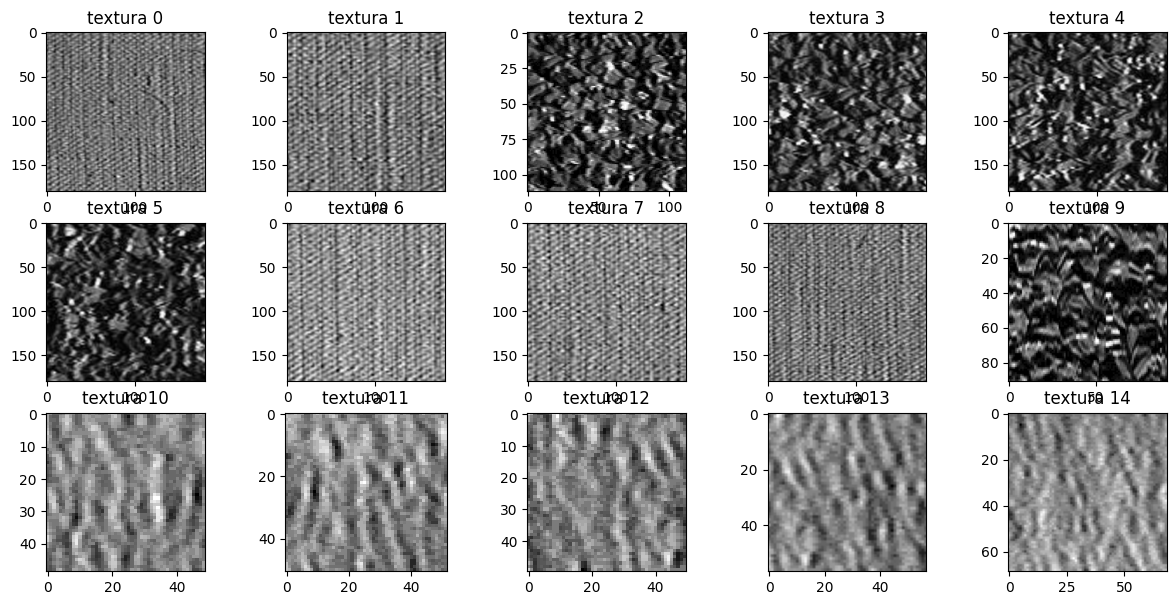

                                       contrast  correlation  dissimilarity  \
../IMG/texturas_fisher/textura_1.tif   0.573658     0.070997       0.524969   
../IMG/texturas_fisher/textura_2.tif   0.627154     0.222298       0.554744   
../IMG/texturas_fisher/textura_3.tif   0.778653     0.359758       0.529951   
../IMG/texturas_fisher/textura_4.tif   0.437422     0.608638       0.361954   
../IMG/texturas_fisher/textura_5.tif   0.470194     0.591837       0.371692   
../IMG/texturas_fisher/textura_6.tif   0.344039     0.630312       0.295287   
../IMG/texturas_fisher/textura_7.tif   0.641479     0.200681       0.565699   
../IMG/texturas_fisher/textura_8.tif   0.701248     0.146584       0.601436   
../IMG/texturas_fisher/textura_9.tif   0.655556     0.060478       0.579026   
../IMG/texturas_fisher/textura_10.tif  0.872453     0.287170       0.573157   
../IMG/texturas_fisher/textura_11.tif  0.360399     0.554662       0.351715   
../IMG/texturas_fisher/textura_12.tif  0.349294     

In [10]:
#*********************************
#      PROGRAMA PRINCIPAL  SBS   *
#*********************************
colores = {1:'red', 2:'blue', 3:'green'}
sel_features = 2     # numero de características seleccionadas
level = 4            # numero de niveles (Haralick)

# extracción de caracteristicas (incluye la clase de cada imagen)
df = feature_extraction (level)


# no empleamos la ultima columna ya que en ella está la clase
cols = df.shape[1] -1    #numero de columnas
print('columnas: ',cols)
col_features = df.columns

# numero de clases
clases = len(df['clase'].unique())

#% combinaciones caracteristicas 
combs = np.array(list(combinations(np.arange(cols),cols-1))).reshape(-1,cols-1)

umbral = sel_features
t = cols-1

while(umbral<=t):
    J = np.zeros(len(combs))
    
    for i in range(len(combs)):
        a = combs[i]
        sub_data = []
        for k in range(1,clases+1):
            #%Seleccionamos las caracteristicas
            id_class= df['clase']==k
            tmp = df[id_class]
            sub_data.append(tmp[col_features[a]].to_numpy())
        
        # Determinamos el indice de Fisher para dichas columnas
        J[i],Gn, Vk = fisher_extraction_list(sub_data,t, clases)
        oldJ = J
        old_comb= combs
        
        #% impresion resultados
        print(f'  > feature = ({a})  >> J[{i}]= \t {J[i]} ')
    
        
        #%fin impresion
    
    t = t-1
    best= np.argmax(J)
    vector= combs[best]
    combs =  np.array(list(combinations(vector,len(vector)-1))).reshape(-1,len(vector)-1)


 Mejor Combinacion de 2 caracteristicas:
Index(['contrast', 'dissimilarity'], dtype='object')


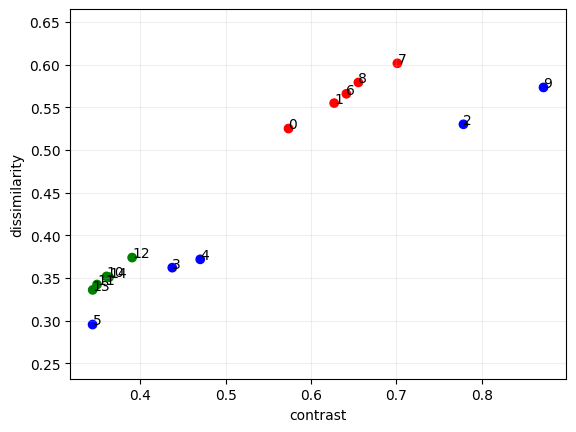

In [11]:
print(f'\n Mejor Combinacion de {umbral} caracteristicas:')
best = np.argmax(oldJ)

a= old_comb[best]
feature_selected = col_features[a]
print(feature_selected)
data_selection= df[feature_selected]

if sel_features==2:
    x = df[feature_selected[0]]
    y = df[feature_selected[1]]
    plt.figure()
    plt.scatter(x,y, color =df['clase'].replace(colores))
    for i in range(len(x)):
        plt.text(x.iloc[i],y.iloc[i], f'{i}')
    plt.xlabel(feature_selected[0])
    plt.ylabel(feature_selected[1])
    plt.grid('both', alpha=0.2)
    plt.axis('equal')
    plt.show()